In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchtext
import os
from pathlib import Path

In [2]:
PATH = Path('./data')
os.listdir(PATH)

['sample_submission.csv',
 'submission.csv',
 'test.csv',
 'test_clean.csv',
 'train.csv',
 'train_clean.csv']

In [3]:
#!pip install transformers

In [5]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [6]:
tokens = tokenizer.tokenize('#Hello WORLD how ARE yoU?')

tokens

['#', 'hello', 'world', 'how', 'are', 'you', '?']

In [7]:
tokenizer.convert_tokens_to_ids(tokens)

[1001, 7592, 2088, 2129, 2024, 2017, 1029]

In [8]:
max_input_length = tokenizer.max_model_input_sizes['bert-base-uncased']

def tokenize_and_cut(sentence):
    tokens = tokenizer.tokenize(sentence) 
    tokens = tokens[:max_input_length-2]
    return tokens

In [9]:
ID = torchtext.data.RawField()
KEYWORD = torchtext.data.RawField()
LOCATION = torchtext.data.RawField()

TEXT = torchtext.data.Field(batch_first = True,
                  use_vocab = False,
                  tokenize = tokenize_and_cut,
                  preprocessing = tokenizer.convert_tokens_to_ids,
                  init_token = tokenizer.cls_token_id,
                  eos_token = tokenizer.sep_token_id,
                  pad_token = tokenizer.pad_token_id,
                  unk_token = tokenizer.unk_token_id)

LABEL = torchtext.data.LabelField(dtype = torch.long)

dataset = torchtext.data.TabularDataset(
    path = PATH / 'train.csv',
    format = 'CSV',
    fields = [('id', ID), ('keyword', KEYWORD), ('location', LOCATION), ('text', TEXT), ('target', LABEL)],
    skip_header = True
)

len(dataset)

C:\Users\sensio\miniconda3\lib\site-packages\torchtext\data\field.py:36: UserWarning: RawField class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)
C:\Users\sensio\miniconda3\lib\site-packages\torchtext\data\field.py:150: UserWarning: Field class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)
C:\Users\sensio\miniconda3\lib\site-packages\torchtext\data\field.py:150: UserWarning: LabelField class will be retired in the 0.8.0 release and moved to torc

7613

In [10]:
ix = 0
print(vars(dataset.examples[ix]))

{'id': '1', 'keyword': '', 'location': '', 'text': [2256, 15616, 2024, 1996, 3114, 1997, 2023, 1001, 8372, 2089, 16455, 9641, 2149, 2035], 'target': '1'}


In [11]:
train_dataset, valid_dataset = dataset.split(
    split_ratio=0.6,
    stratified=True,
    strata_field='target'
)

len(train_dataset), len(valid_dataset)

(4568, 3045)

In [12]:
#MAX_VOCAB_SIZE = 10000

#TEXT.build_vocab(train_dataset, 
#                 max_size=MAX_VOCAB_SIZE,
#                 vectors="glove.6B.100d",
#                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_dataset)

In [14]:
len(LABEL.vocab)

2

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"

dataloader = {
    'train': torchtext.data.BucketIterator(train_dataset, batch_size=64, shuffle=True, device=device),
    'val': torchtext.data.BucketIterator(valid_dataset, batch_size=100, device=device)
}

C:\Users\sensio\miniconda3\lib\site-packages\torchtext\data\iterator.py:48: UserWarning: BucketIterator class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [26]:
from transformers import BertModel

class BERT(torch.nn.Module):
    def __init__(self, hidden_size=128, num_layers=2, n_outputs=2, bidirectional=True, dropout=0):
        super().__init__()
        
        #self.embedding = torch.nn.Embedding(input_dim, embedding_dim)
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        
        for name, param in self.bert.named_parameters():                
            param.requires_grad = False
        
        self.rnn = torch.nn.LSTM(
            input_size=self.bert.config.to_dict()['hidden_size'], 
            hidden_size=hidden_size, 
            num_layers=num_layers,
            bidirectional=bidirectional,
            dropout=dropout,
            batch_first=True
        )
        self.fc = torch.nn.Linear(2*hidden_size if bidirectional else hidden_size, n_outputs)
        
    def forward(self, text):
        with torch.no_grad():
            embedded = self.bert(text)[0]
        output, _ = self.rnn(embedded)
        # [bs, l, h]
        return self.fc(output[:,-1,:].squeeze(1))

In [42]:
import sklearn.metrics as m
from tqdm import tqdm

def fit(model, dataloader, epochs=10, lr=1e-3):
    model.to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr)

    hist = {'loss': [], 'f1': [], 'val_loss': [], 'val_f1': []}
    best_f1 = 0.
    for e in range(1, epochs+1):
        model.train()
        l, f1s = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            optimizer.zero_grad()
            y_pred = model(batch.text)
            loss = criterion(y_pred, batch.target)
            l.append(loss.item())
            loss.backward()
            optimizer.step()
            y_pred = torch.argmax(y_pred, axis=1)
            f1s.append(m.f1_score(batch.target.cpu(), y_pred.cpu()))
            bar.set_description(f"loss {np.mean(l):.5f} f1 {np.mean(f1s):.5f}")
        hist['loss'].append(np.mean(l))
        hist['f1'].append(np.mean(f1s))
        model.eval()
        l, acc, f1s = [], [], []
        with torch.no_grad():
            pg_bar = tqdm(dataloader['val'])
            for batch in pg_bar:
                y_pred = model(batch.text)
                loss = criterion(y_pred, batch.target)
                l.append(loss.item())          
                y_pred = torch.argmax(y_pred, axis=1)
                f1s.append(m.f1_score(batch.target.cpu(), y_pred.cpu()))
                pg_bar.set_description(f"val_loss {np.mean(l):.5f} val_f1 {np.mean(f1s):.5f}")
        hist['val_loss'].append(np.mean(l))
        hist['val_f1'].append(np.mean(f1s))
        if hist["val_f1"][-1] > best_f1:
            best_f1 = hist["val_f1"][-1]
            torch.save(model.state_dict(), 'ckpt.pt')
        print(f'Epoch {e}/{epochs} loss {hist["loss"][-1]:.5f} f1 {hist["f1"][-1]:.5f} val_loss {hist["val_loss"][-1]:.5f} val_f1 {hist["val_f1"][-1]:.5f}')
    model.load_state_dict(torch.load('ckpt.pt'))
    return hist

In [43]:
model = BERT()

hist = fit(model, dataloader)

  0%|                                                 | 0/72 [00:00<?, ?it/s]C:\Users\sensio\miniconda3\lib\site-packages\torchtext\data\batch.py:23: UserWarning: Batch class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)
  0%|                                                 | 0/72 [00:00<?, ?it/s]

Epoch 1/10 loss 0.66682 f1 0.29174 val_loss 0.64448 val_f1 0.62714


  0%|                                                 | 0/72 [00:00<?, ?it/s]

Epoch 2/10 loss 0.64177 f1 0.50938 val_loss 0.65102 val_f1 0.23931


  0%|                                                 | 0/72 [00:00<?, ?it/s]

Epoch 3/10 loss 0.61471 f1 0.56566 val_loss 0.55959 val_f1 0.70370


  0%|                                                 | 0/72 [00:00<?, ?it/s]

Epoch 4/10 loss 0.52392 f1 0.71359 val_loss 0.51254 val_f1 0.68529


  0%|                                                 | 0/72 [00:00<?, ?it/s]

Epoch 5/10 loss 0.46439 f1 0.75942 val_loss 0.47048 val_f1 0.76374


  0%|                                                 | 0/72 [00:00<?, ?it/s]

Epoch 6/10 loss 0.43488 f1 0.76979 val_loss 0.42608 val_f1 0.77417


  0%|                                                 | 0/72 [00:00<?, ?it/s]

Epoch 7/10 loss 0.42304 f1 0.78016 val_loss 0.46245 val_f1 0.77713


  0%|                                                 | 0/72 [00:00<?, ?it/s]

Epoch 8/10 loss 0.39801 f1 0.79162 val_loss 0.44164 val_f1 0.77798


loss 0.31342 f1 0.82143:   0%|                        | 0/72 [00:00<?, ?it/s]

Epoch 9/10 loss 0.37966 f1 0.80701 val_loss 0.41514 val_f1 0.78735


val_loss 0.47631 val_f1 0.77347: 100%|███████| 31/31 [00:09<00:00,  3.32it/s]


Epoch 10/10 loss 0.36388 f1 0.81163 val_loss 0.47631 val_f1 0.77347


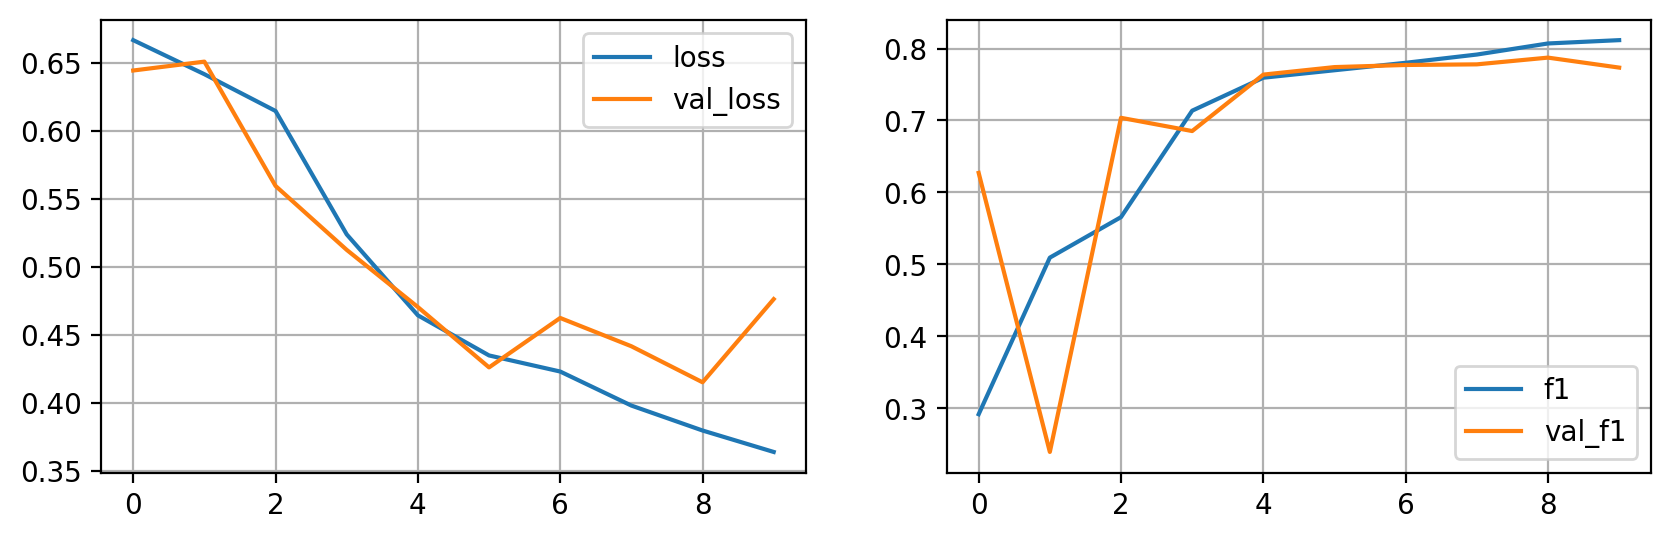

In [44]:
def plot(hist):
    fig = plt.figure(dpi=200,figsize=(10,3))
    ax = plt.subplot(121)
    hist = pd.DataFrame(hist)
    hist[['loss', 'val_loss']].plot(ax=ax, grid=True)
    ax = plt.subplot(122)
    hist[['f1', 'val_f1']].plot(ax=ax, grid=True)
    plt.show()
    
plot(hist)

In [31]:
test_dataset = torchtext.data.TabularDataset(
    path = PATH / 'test.csv',
    format = 'CSV',
    fields = [('id', ID), ('keyword', KEYWORD), ('location', LOCATION), ('text', TEXT)],
    skip_header = True
)

len(test_dataset)

C:\Users\sensio\miniconda3\lib\site-packages\torchtext\data\example.py:68: UserWarning: Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.', UserWarning)
C:\Users\sensio\miniconda3\lib\site-packages\torchtext\data\example.py:78: UserWarning: Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.', UserWarning)


3263

In [32]:
ix = 3258
print(vars(test_dataset.examples[ix]))

{'id': '10861', 'keyword': '', 'location': '', 'text': [8372, 3808, 3050, 3349, 1057, 2080, 3808, 3435, 24454, 2015, 1060, 2099, 7962]}


In [33]:
test_dataloader = torchtext.data.BucketIterator(test_dataset, batch_size=64, shuffle=False, device=device)

C:\Users\sensio\miniconda3\lib\site-packages\torchtext\data\iterator.py:48: UserWarning: BucketIterator class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [34]:
def predict():
    model.eval()
    preds = torch.tensor([]).to(device)
    with torch.no_grad():
        for batch in tqdm(test_dataloader):
            y_pred = model(batch.text)        
            y_pred = torch.argmax(y_pred, axis=1)
            preds = torch.cat([preds, y_pred])
    return preds

In [35]:
preds = predict()
preds

  0%|                                                 | 0/51 [00:00<?, ?it/s]C:\Users\sensio\miniconda3\lib\site-packages\torchtext\data\batch.py:23: UserWarning: Batch class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)
100%|████████████████████████████████████████| 51/51 [00:10<00:00,  4.77it/s]


tensor([1., 1., 1.,  ..., 1., 1., 1.], device='cuda:0')

In [36]:
submission = pd.read_csv(PATH  / 'sample_submission.csv')
submission

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0


In [37]:
submission.target = preds.cpu().long()
submission

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [41]:
submission.to_csv('submission.csv', index=False)